In [94]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import data

In [95]:
## Defined functions

def convert_drugs(value):
    """
    Clean up weird values for drugs text box
    :param value: value to convert
    :return: categegorical value
    """
    if value == "Caffeine (energy drinks/coffee)" or \
        value == "Caffeine (energy drinks/coffee), Kohvi on elu, kohvi on armastus :) " or \
        value == "Herbal tea" or value == 'herbal tea' or value == "tee":
        return "Caffeine"
    elif value.startswith("Ei") or value == "No" or value == "no" or value == "food" or value == "sweets":
        return "No"
    return value

def merge_ids(id, *other_ids):
    for other_id in other_ids:
        common["user_id"].loc[common["user_id"] == other_id] = id
        general["user_id"].loc[general["user_id"] == other_id] = id


In [96]:
## Read data in

general = pd.read_csv("out_general.csv", names=["row", "ts", "user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     usecols=["user_id", "gender", "age", "prev_test", "pys_activity", "sick", "pain_general", "pain_digest", "sleep_regular"], 
                     header=0, 
                     dtype={'gender':'category', 
                            'age':'category', 
                            'prev_test':'category', 
                            'pys_activity':'category', 
                            'sick':'category', 
                            'pain_general':'category', 
                            'pain_digest':'category', 
                            'sleep_regular':'category'
                           })
common = pd.read_csv("out_common.csv", names=["ts", "user_id", "res_number", "res_reaction", "res_visual", "hungry", "sleepy", "time_sleep", "time_wake", "stress",
                                              "fatigue_mental", "fatigue_physical", "drugs"], header=0, 
                     converters={'ts':lambda v: pd.Timestamp(v), 
                                 'time_sleep':lambda v: pd.to_timedelta(v), 
                                 'time_wake':lambda v: pd.to_timedelta(v),
                                 'drugs': convert_drugs},
                     dtype={'hungry':'category', 
                            'sleepy':'category', 
                            'stress':'category', 
                            'fatigue_mental':'category', 
                            'fatigue_physical':'category'})

common["drugs"] = common["drugs"].astype('category')

In [118]:
any(common.user_id == 23)

False

In [119]:
## User related modifications

## Alter user_ids
pd.set_option("mode.chained_assignment", None)

merge_ids(1, 29, 33, 34, 36)
merge_ids(35, 37)
merge_ids(13, 4, 7)
merge_ids(17, 41)
merge_ids(10, 38)

## Delete not suitable users

## Based on user_id

common = common[
    (common["user_id"] != 9) &
    (common["user_id"] != 10) &
    (common["user_id"] != 14) &
    (common["user_id"] != 18) &
    (common["user_id"] != 30) &
    (common["user_id"] != 31)
    ]

## Based on stress levels

common = common[
    (common["stress"] != '4') &
    (common["stress"] != '5')
    ]

## Sick people

sick_people_ids = np.array(general.loc[general["sick"] == "Yes", ["user_id"]].values.tolist()).flatten().tolist()

for usr_id in sick_people_ids:
    common = common[common["user_id"] != usr_id]

### Add times from waking up

In [68]:
common["stress"].cat.categories

Index(['1', '2', '3', '4', '5'], dtype='object')

In [84]:
common["drugs"].value_counts()

#print(common[common["hungry"] == '4'])

No          156
Caffeine     35
Alcohol      20
Name: drugs, dtype: int64

In [160]:
common["user_id"].value_counts()
## So many user_ids with only one entry? 
## Some of these should be removed before => Can't be done without knowing the names. 

6     17
11    14
16    14
23    14
2     14
13    13
28    12
15    12
8     12
3     12
12    11
19    11
21     9
24     9
25     9
26     9
27     9
17     8
1      8
20     8
5      7
32     5
22     4
35     3
Name: user_id, dtype: int64

In [83]:
## Too few rows of hungry level 4 and 5 to draw conclusions 

hungry_level_1 = common.loc[common["hungry"] == '1', ["res_number", "res_reaction", "res_visual"]]
hungry_level_2 = common.loc[common["hungry"] == '2', ["res_number", "res_reaction", "res_visual"]]
hungry_level_3 = common.loc[common["hungry"] == '3', ["res_number", "res_reaction", "res_visual"]]

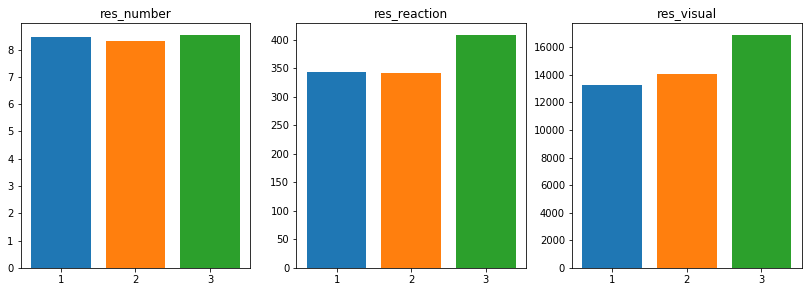

In [82]:
def draw_bar_plot(plot, title, x_axis_list, y_axis_list):
    plot.set_title(title)

    for i in range(0, len(x_axis_list)):
        plot.bar(x_axis_list[i], y_axis_list[i], align = "center")
        
        
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize = (14, 4.5)) 

draw_bar_plot(plt1, "res_number", ['1', '2', '3'], [
    hungry_level_1["res_number"].mean().round(2), 
    hungry_level_2["res_number"].mean().round(2),
    hungry_level_3["res_number"].mean().round(2)
    ])

draw_bar_plot(plt2, "res_reaction", ['1', '2', '3'], [
    hungry_level_1["res_reaction"].mean().round(2), 
    hungry_level_2["res_reaction"].mean().round(2),
    hungry_level_3["res_reaction"].mean().round(2)
    ])

draw_bar_plot(plt3, "res_visual", ['1', '2', '3'], [
    hungry_level_1["res_visual"].mean().round(2), 
    hungry_level_2["res_visual"].mean().round(2),
    hungry_level_3["res_visual"].mean().round(2)
    ])

## Add time from wakeup

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [16]:
ts_wake = common.ts.apply(lambda x: x.replace(hour=0, minute=0, second=0)) + common.time_wake
delta = (common.ts - ts_wake) # TODO minus deltas
common["awake_delta"] = delta  / np.timedelta64(1, 's')

In [6]:
model = ols("res_number ~ awake_delta + hungry + sleepy + stress + fatigue_mental", common).fit()
model.summary()

NameError: name 'common' is not defined

In [7]:
fig,plots  = plt.subplots(1,1)
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

NameError: name 'plt' is not defined